Вам будет предоставлен датасет. В нем посчитано количество событий в группировке по:

url - адрес страницы         
event_name - название события      
product_category - категория продукта        
event_timestamp - время событий округленное до часу        
device_type - тип устройства

Необходимо будет придумать модель и написать код, который позволит найти отклонения во временном рядом. В задаче необходимо будет дать определение тому, что вы называете отклонением, придумать модель, которая будет осуществлять поиск таких отклонений. Это может быть сравнение нескольких моделей, для поиска наилучшей. Определить каким продуктам, устройствам или адресам страниц свойственны отклонения. Результатом работы должен быть код на Python. А так же презентация результатов самих моделей.

__Определение отклонения__

1. Точечное значние величины, которому соответствует сильно отлежащий от медианы остаток (остаток получен вследствие разложения временного ряда на тренд и сезон)
2. Временной промежуток, в котором скорость и направление роста тренда отличается от большей части временного ряда

Мы будем разлагать временной ряд на тренд, сезон и остаток с помощью аддитивной модели, так как выделенные ей аномалии более интуитивно очевидны (то есть заметны при наивном взгляде на изначальный временной ряд), по сравнению с аномалиями выделенными мультипликативной моделью

Поскольку в данных присутсвует два типа сезонных колебаний (посуточные и понедельные), то для обнаружения истинного тренда мы будем вторично разлагать тренд, полученный при разложении изначального временного ряда

# Первоначальная обработка

In [1]:
#!pip install adtk

In [55]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.seasonal import seasonal_decompose, MSTL
from adtk.detector import QuantileAD
from scipy.stats import shapiro
from scipy.stats import kstest

df = pd.read_csv('anomaly_detection_v2.csv')

df['event_timestamp'] = df['event_timestamp'].apply(lambda date_str: dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S'))

df = df.sort_values(by='event_timestamp')
df = df.reset_index(drop=True)

df['date'] = df['event_timestamp'].apply(lambda x: x.date())
df['week'] = df['event_timestamp'].apply(lambda x: x.isocalendar()[1])
df['month'] = df['event_timestamp'].apply(lambda x: x.month)

In [3]:
df

event_name     event_timestamp        device_type  event_count  \
0        events.pageLoad 2023-07-31 21:00:00      HIGHEND_PHONE            1   
1        events.pageLoad 2023-07-31 21:00:00      HIGHEND_PHONE            1   
2        events.pageLoad 2023-07-31 21:00:00      HIGHEND_PHONE            4   
3        events.pageLoad 2023-07-31 21:00:00      HIGHEND_PHONE            8   
4        events.pageLoad 2023-07-31 21:00:00      HIGHEND_PHONE           10   
...                  ...                 ...                ...          ...   
6078200  events.pageLoad 2023-10-31 20:00:00      HIGHEND_PHONE            4   
6078201  events.pageLoad 2023-10-31 20:00:00      HIGHEND_PHONE            1   
6078202  events.pageLoad 2023-10-31 20:00:00      HIGHEND_PHONE            2   
6078203  events.pageLoad 2023-10-31 20:00:00  PERSONAL_COMPUTER            4   
6078204  events.pageLoad 2023-10-31 20:00:00  PERSONAL_COMPUTER            1   

         url_id  product_category_id        date  week  month  
0           612                    3  2023-07-31    31      7  
1          1504                    0  2023-07-31    31      7  
2           295                    4  2023-07-31    31      7  
3           790                    4  2023-07-31    31      7  
4           739                    0  2023-07-31    31      7  
...         ...                  ...         ...   ...    ...  
6078200    2066                    0  2023-10-31    44     10  
6078201     827                    2  2023-10-31    44     10  
6078202   43764                    2  2023-10-31    44     10  
6078203    1408                    0  2023-10-31    44     10  
6078204     974                    6  2023-10-31    44     10  

[6078205 rows x 9 columns]

In [4]:
view = df.groupby(['event_timestamp']).agg({'event_count':'sum','url_id':'nunique','product_category_id':'nunique', 'week':'min', 'month':'min'})
view.rename(columns={'url_id':'nunique_url_id', 'product_category_id':'nunique_product_category_id'}, inplace=True)
view['events_per_url'] = view['event_count'] / view['nunique_url_id']
view

event_count  nunique_url_id  nunique_product_category_id  \
event_timestamp                                                                 
2023-07-31 21:00:00        32119            1079                            7   
2023-07-31 22:00:00        21834             942                            7   
2023-07-31 23:00:00        17534             873                            7   
2023-08-01 00:00:00        16931             840                            7   
2023-08-01 01:00:00        17421             830                            7   
...                          ...             ...                          ...   
2023-10-31 16:00:00       114214            2181                            7   
2023-10-31 17:00:00       106444            2147                            7   
2023-10-31 18:00:00       118371            2068                            7   
2023-10-31 19:00:00        86393            1964                            7   
2023-10-31 20:00:00        61437            1662                            7   

                     week  month  events_per_url  
event_timestamp                                   
2023-07-31 21:00:00    31      7       29.767377  
2023-07-31 22:00:00    31      7       23.178344  
2023-07-31 23:00:00    31      7       20.084765  
2023-08-01 00:00:00    31      8       20.155952  
2023-08-01 01:00:00    31      8       20.989157  
...                   ...    ...             ...  
2023-10-31 16:00:00    44     10       52.367721  
2023-10-31 17:00:00    44     10       49.578016  
2023-10-31 18:00:00    44     10       57.239362  
2023-10-31 19:00:00    44     10       43.988289  
2023-10-31 20:00:00    44     10       36.965704  

[2208 rows x 6 columns]

In [5]:
# временной ряд
x = view.index

# метки временной оси для графика
sep = [datetime for datetime in view.index if datetime.hour==0]
labels = [s.strftime('%d.%m') for s in sep]

# Сумма событий

In [6]:
event_count = view.event_count

In [7]:
event_count

event_timestamp
2023-07-31 21:00:00     32119
2023-07-31 22:00:00     21834
2023-07-31 23:00:00     17534
2023-08-01 00:00:00     16931
2023-08-01 01:00:00     17421
                        ...  
2023-10-31 16:00:00    114214
2023-10-31 17:00:00    106444
2023-10-31 18:00:00    118371
2023-10-31 19:00:00     86393
2023-10-31 20:00:00     61437
Name: event_count, Length: 2208, dtype: int64

##### Seasonal Decomposition

In [8]:
result = MSTL(event_count, periods=[24*1, 24*7]).fit()

In [9]:
result.weights

event_timestamp
2023-07-31 21:00:00    1.0
2023-07-31 22:00:00    1.0
2023-07-31 23:00:00    1.0
2023-08-01 00:00:00    1.0
2023-08-01 01:00:00    1.0
                      ... 
2023-10-31 16:00:00    1.0
2023-10-31 17:00:00    1.0
2023-10-31 18:00:00    1.0
2023-10-31 19:00:00    1.0
2023-10-31 20:00:00    1.0
Name: robust_weight, Length: 2208, dtype: float64

##### Анализ остатков

In [10]:
residuals = result.resid[~result.resid.isna()].tolist()

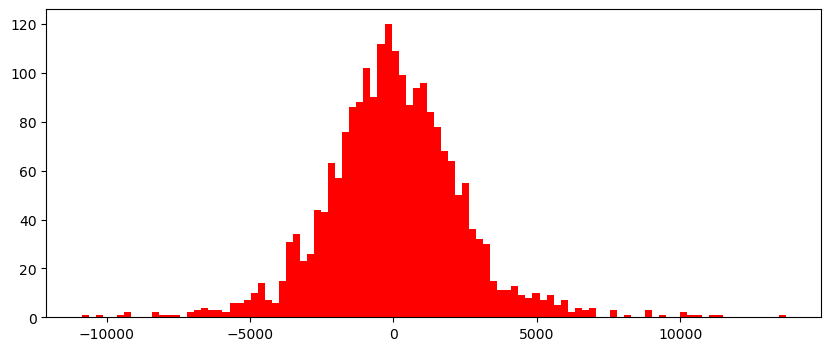

In [11]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=100)
plt.hist(residuals, bins=100, color='r')
plt.show()

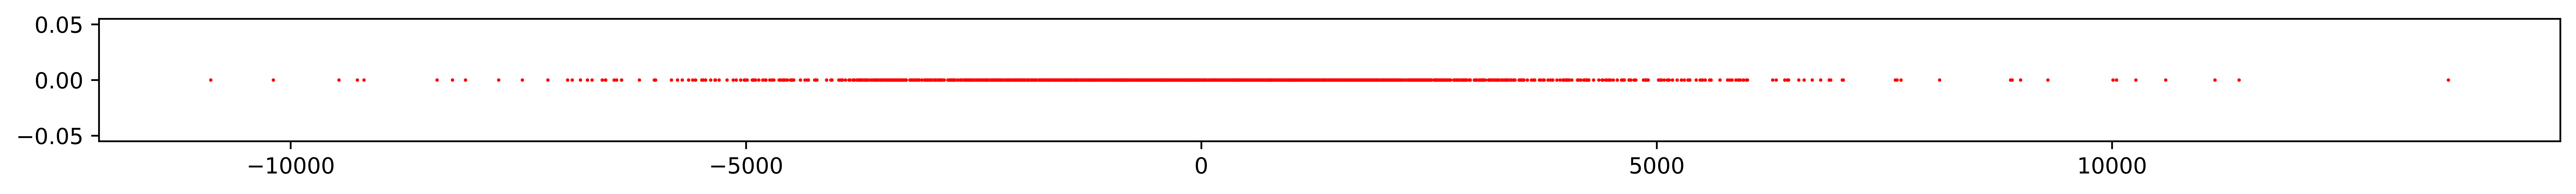

In [12]:
fig, axes = plt.subplots(figsize=(20, 1), dpi=1000)
plt.scatter(residuals, [0]*len(residuals), color='r', s=0.3)
plt.show()

In [13]:
# если True, то остатки не распределены нормально
shapiro(np.array(residuals))[1] < 0.01

True

In [14]:
# если True, то остатки не распределены нормально
kstest(np.array(residuals), 'norm')[1] < 0.01

True

##### Поиск аномалий через выделение 0.5%-ых квантилей с обеих сторон

In [15]:
quantile_ad = QuantileAD(high=0.995, low=0.005)
anomalies = quantile_ad.fit_detect(result.resid[~result.resid.isna()])

In [16]:
# для графика

avg = np.mean(result.resid)

highlight_observed_low = {}
highlight_observed_high = {}
for datetime in result.observed.index:
    if np.isnan(result.resid[datetime]):
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_observed_low[datetime] = result.observed[datetime]
            highlight_observed_high[datetime] = np.nan
        else:
            highlight_observed_low[datetime] = np.nan
            highlight_observed_high[datetime] = result.observed[datetime]
highlight_observed_low = pd.Series(highlight_observed_low)
highlight_observed_high = pd.Series(highlight_observed_high)

highlight_residual_low = {}
highlight_residual_high = {}
for datetime in result.resid.index:
    if np.isnan(result.resid[datetime]):
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_residual_low[datetime] = result.resid[datetime]
            highlight_residual_high[datetime] = np.nan
        else:
            highlight_residual_low[datetime] = np.nan
            highlight_residual_high[datetime] = result.resid[datetime]
highlight_residual_low = pd.Series(highlight_residual_low)
highlight_residual_high = pd.Series(highlight_residual_high)

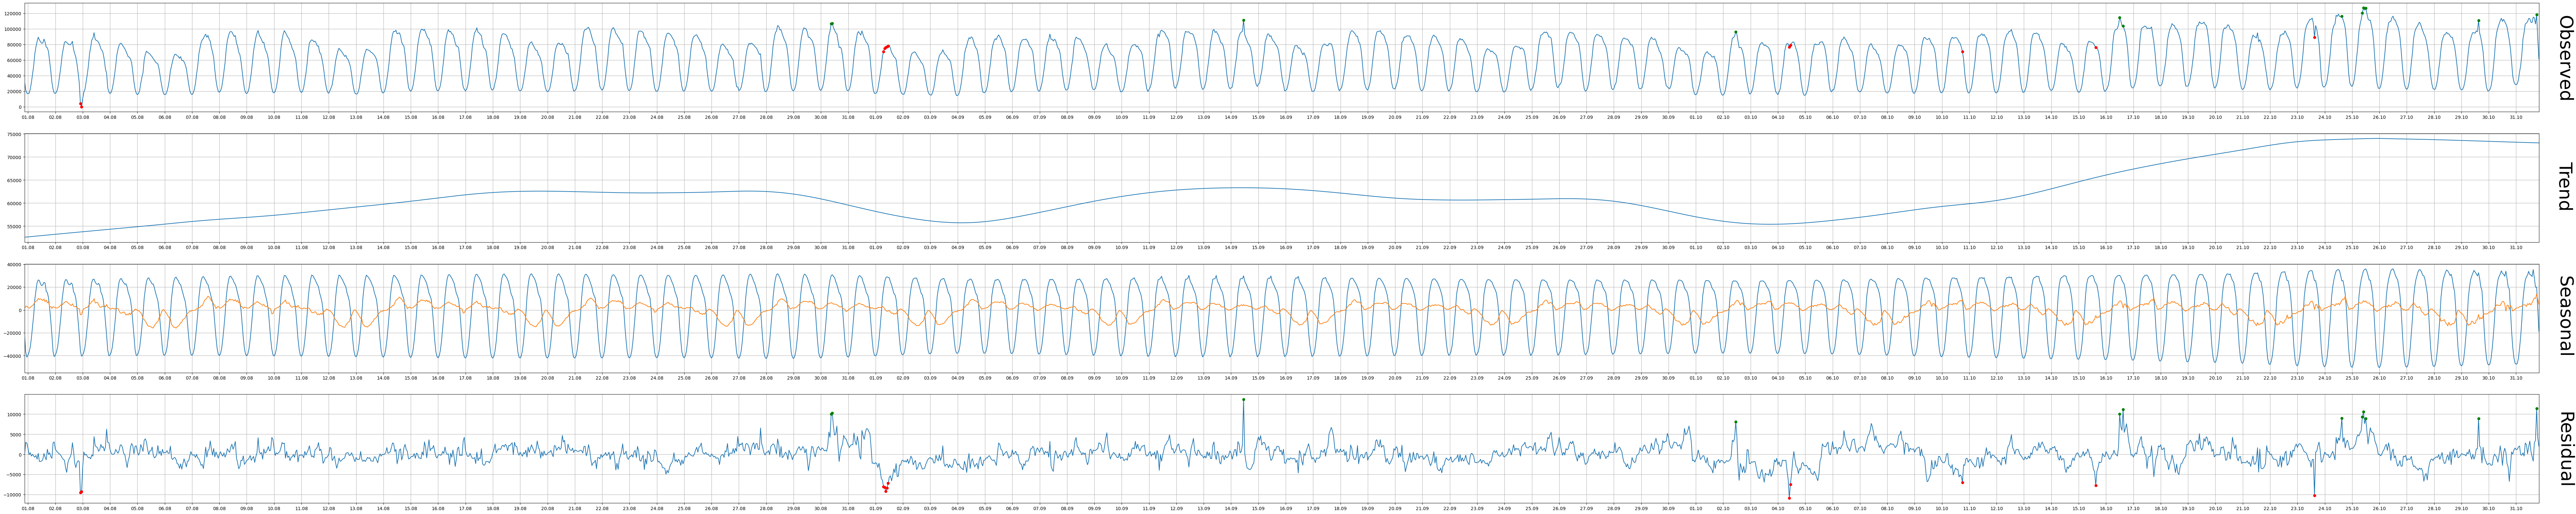

In [17]:
fig, axes = plt.subplots(4, figsize=(100, 20), dpi=100)

a = x[0]
b = x[-1]

for i in range(4):
    axes[i].set_xlim(a, b)
    axes[i].set_xticks(sep)
    axes[i].set_xticklabels(labels)
    axes[i].grid()

axes[0].plot(x, result.observed)
axes[0].scatter(x, highlight_observed_low, s=30, c='r', zorder=10)
axes[0].scatter(x, highlight_observed_high, s=30, c='g', zorder=10)
axes[0].set_title('Observed', x=1.01, y=0.1, rotation = -90, fontsize=40)
#axes[0].axvline(x = x[1731], color = 'y', linewidth=4, alpha=0.6)

axes[1].plot(x, result.trend)
axes[1].set_title('Trend', x=1.01, y=0.3, rotation = -90, fontsize=40)
#axes[1].axvline(x = x[1731], color = 'y', linewidth=4, alpha=0.6)

axes[2].plot(x, result.seasonal)
axes[2].set_title('Seasonal', x=1.01, y=0.15, rotation = -90, fontsize=40)

axes[3].plot(x, result.resid)
axes[3].scatter(x, highlight_residual_low, s=30, c='r', zorder=10)
axes[3].scatter(x, highlight_residual_high, s=30, c='g', zorder=10)
axes[3].set_title('Residual', x=1.01, y=0.15, rotation = -90, fontsize=40)

# plt.savefig('Anomalies.jpg')

plt.show()

In [18]:
# список аномально низкой частоты событий
event_count_low = highlight_observed_low[highlight_observed_low.notna()]
event_count_low

2023-08-02 22:00:00     4305.0
2023-08-02 23:00:00       40.0
2023-09-01 07:00:00    71083.0
2023-09-01 08:00:00    75224.0
2023-09-01 09:00:00    76360.0
2023-09-01 10:00:00    77056.0
2023-09-01 11:00:00    78017.0
2023-10-04 10:00:00    76717.0
2023-10-04 11:00:00    79396.0
2023-10-10 18:00:00    71034.0
2023-10-15 15:00:00    76497.0
2023-10-23 15:00:00    89326.0
dtype: float64

In [19]:
# список аномально высокой частоты событий
event_count_high = highlight_observed_high[highlight_observed_high.notna()]
event_count_high

2023-08-30 09:00:00    106858.0
2023-08-30 10:00:00    107145.0
2023-09-14 11:00:00    111546.0
2023-10-02 11:00:00     96493.0
2023-10-16 12:00:00    114812.0
2023-10-16 15:00:00    103860.0
2023-10-24 15:00:00    116464.0
2023-10-25 09:00:00    120463.0
2023-10-25 10:00:00    126995.0
2023-10-25 12:00:00    126731.0
2023-10-29 15:00:00    110883.0
2023-10-31 18:00:00    118371.0
dtype: float64

# Среднее количество событий на URL

In [78]:
x = view.index
sep = [datetime for datetime in view.index if datetime.hour==0]
labels = [s.strftime('%d.%m') for s in sep]

events_per_url = view.events_per_url

In [79]:
events_per_url

event_timestamp
2023-07-31 21:00:00    29.767377
2023-07-31 22:00:00    23.178344
2023-07-31 23:00:00    20.084765
2023-08-01 00:00:00    20.155952
2023-08-01 01:00:00    20.989157
                         ...    
2023-10-31 16:00:00    52.367721
2023-10-31 17:00:00    49.578016
2023-10-31 18:00:00    57.239362
2023-10-31 19:00:00    43.988289
2023-10-31 20:00:00    36.965704
Name: events_per_url, Length: 2208, dtype: float64

In [80]:
url_analysis = view[['events_per_url']].reset_index()

In [83]:
url_analysis.query('event_timestamp >= "2023-10-02 22:00:00" and event_timestamp <= "2023-10-05 22:00:00"')

event_timestamp  events_per_url
1513 2023-10-02 22:00:00       27.908088
1514 2023-10-02 23:00:00       22.314094
1515 2023-10-03 00:00:00       22.405080
1516 2023-10-03 01:00:00       24.728878
1517 2023-10-03 02:00:00       28.294256
...                  ...             ...
1581 2023-10-05 18:00:00       35.653787
1582 2023-10-05 19:00:00       33.471763
1583 2023-10-05 20:00:00       29.950875
1584 2023-10-05 21:00:00       23.995114
1585 2023-10-05 22:00:00       19.461468

[73 rows x 2 columns]

In [87]:
view.query('event_timestamp >= "2023-10-02 22:00:00" and event_timestamp <= "2023-10-05 22:00:00"').head(
)

event_count  nunique_url_id  nunique_product_category_id  \
event_timestamp                                                                 
2023-10-02 22:00:00        22773             816                            7   
2023-10-02 23:00:00        16624             745                            7   
2023-10-03 00:00:00        16759             748                            7   
2023-10-03 01:00:00        19610             793                            7   
2023-10-03 02:00:00        24135             853                            7   

                     week  month  events_per_url  
event_timestamp                                   
2023-10-02 22:00:00    40     10       27.908088  
2023-10-02 23:00:00    40     10       22.314094  
2023-10-03 00:00:00    40     10       22.405080  
2023-10-03 01:00:00    40     10       24.728878  
2023-10-03 02:00:00    40     10       28.294256

In [ ]:
2023-08-02 22:00:00     8.785714
2023-08-02 23:00:00     1.538462
2023-10-03 11:00:00    36.069705
2023-10-03 12:00:00    36.274528
2023-10-03 13:00:00    37.803052
2023-10-03 14:00:00    36.393158
2023-10-03 15:00:00    37.882295
2023-10-03 16:00:00    36.672012
2023-10-03 18:00:00    34.397174
2023-10-04 08:00:00    37.775718
2023-10-04 09:00:00    39.262494
2023-10-04 10:00:00    36.741858

2023-09-14 11:00:00    74.067729
2023-10-02 10:00:00    56.178218
2023-10-02 11:00:00    60.955780
2023-10-02 12:00:00    58.699243
2023-10-02 15:00:00    58.191311
2023-10-02 16:00:00    57.820199
2023-10-02 17:00:00    54.635593
2023-10-02 18:00:00    50.922774
2023-10-03 05:00:00    46.762887
2023-10-03 06:00:00    51.870968
2023-10-30 13:00:00    69.060271
2023-10-31 18:00:00    57.239362

In [81]:
url_analysis

event_timestamp  events_per_url
0    2023-07-31 21:00:00       29.767377
1    2023-07-31 22:00:00       23.178344
2    2023-07-31 23:00:00       20.084765
3    2023-08-01 00:00:00       20.155952
4    2023-08-01 01:00:00       20.989157
...                  ...             ...
2203 2023-10-31 16:00:00       52.367721
2204 2023-10-31 17:00:00       49.578016
2205 2023-10-31 18:00:00       57.239362
2206 2023-10-31 19:00:00       43.988289
2207 2023-10-31 20:00:00       36.965704

[2208 rows x 2 columns]

In [75]:
import plotly.express as px

fig = px.line(url_analysis, x="event_timestamp", y="events_per_url", title='Life expectancy in Canada')



fig.show()

Epoch 1/50
54/54 [==============================] - 2s 12ms/step - loss: 0.0956 - val_loss: 0.0159
Epoch 2/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0331 - val_loss: 0.0147
Epoch 3/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0274 - val_loss: 0.0193
Epoch 4/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0199 - val_loss: 0.0103
Epoch 5/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0129 - val_loss: 0.0076
Epoch 6/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 7/50
54/54 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 8/50
54/54 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/50
54/54 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 10/50
54/54 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/50
54/54 

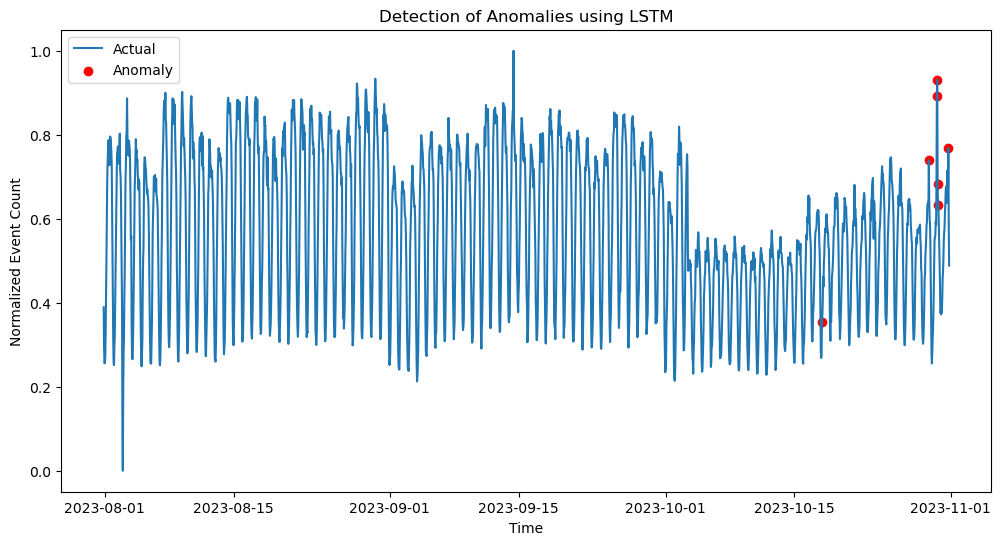

Обнаружено аномалий: 7
Список аномальных дат:
 1875   2023-10-18 00:00:00
2154   2023-10-29 15:00:00
2175   2023-10-30 12:00:00
2176   2023-10-30 13:00:00
2177   2023-10-30 14:00:00
2178   2023-10-30 15:00:00
2205   2023-10-31 18:00:00
Name: event_timestamp, dtype: datetime64[ns]


In [77]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
url_analysis["events_per_url"] = scaler.fit_transform(url_analysis["events_per_url"].values.reshape(-1, 1))


# Преобразование данных в форму, подходящую для LSTM
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)


sequence_length = 50  # Выберите подходящую длину последовательности
X, y = create_sequences(url_analysis["events_per_url"].values, sequence_length)

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Создание и обучение модели LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

# Получение предсказаний
predictions = model.predict(X_test)

# Распределение ошибок предсказания
errors = np.abs(predictions.reshape(-1) - y_test)

# Установка порога для выявления аномалий
threshold = 0.1  # Выберите подходящий порог

# Идентификация отклонений
anomalies = url_analysis.iloc[train_size + sequence_length :][errors > threshold]

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(
    url_analysis["event_timestamp"], url_analysis["events_per_url"], label="Actual"
)
plt.scatter(anomalies["event_timestamp"], anomalies["events_per_url"], color="red", label="Anomaly")
plt.title("Detection of Anomalies using LSTM")
plt.xlabel("Time")
plt.ylabel("Normalized Event Count")
plt.legend()
plt.show()

# Вывод результатов
print("Обнаружено аномалий:", anomalies.shape[0])
print("Список аномальных дат:\n", anomalies["event_timestamp"])

##### Seasonal Decomposition

In [22]:
result = MSTL(events_per_url, periods=[24*1, 24*7]).fit()

##### Анализ остатков

In [23]:
residuals = result.resid[~result.resid.isna()].tolist()

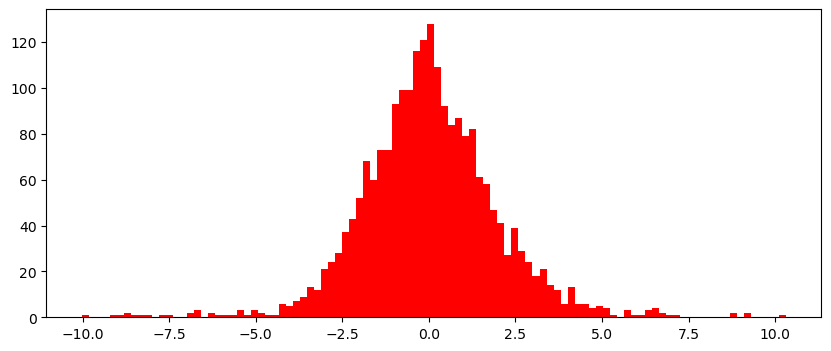

In [24]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=100)
plt.hist(residuals, bins=100, color='r')
plt.show()

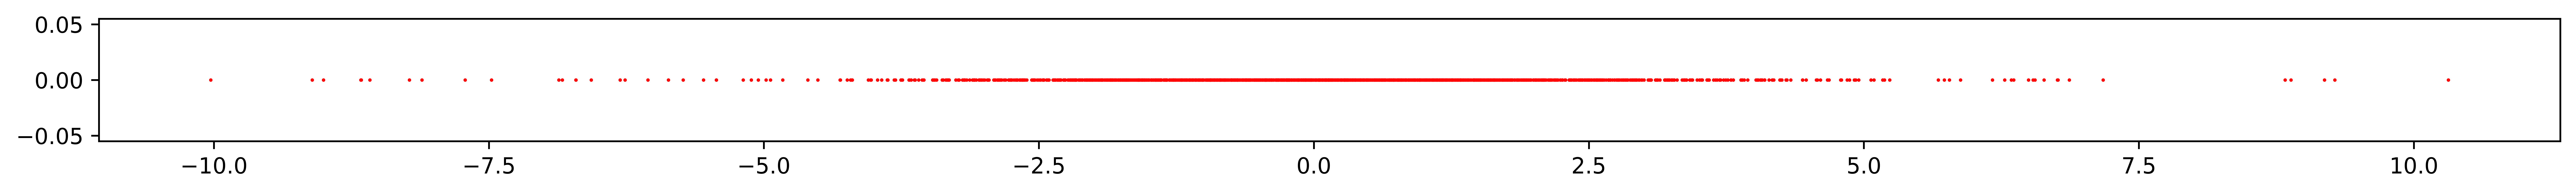

In [25]:
fig, axes = plt.subplots(figsize=(20, 1), dpi=1000)
plt.scatter(residuals, [0]*len(residuals), color='r', s=0.3)
plt.show()

In [26]:
# если True, то остатки не распределены нормально
shapiro(np.array(residuals))[1] < 0.01

True

In [27]:
# если True, то остатки не распределены нормально
kstest(np.array(residuals), 'norm')[1] < 0.01

True

##### Поиск аномалий через выделение 0.5%-ых квантилей с обеих сторон

In [28]:
quantile_ad = QuantileAD(high=0.995, low=0.005)
anomalies = quantile_ad.fit_detect(result.resid[~result.resid.isna()])

In [29]:
# для графика

avg = np.mean(result.resid)

highlight_observed_low = {}
highlight_observed_high = {}
for datetime in result.observed.index:
    if np.isnan(result.resid[datetime]):
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_observed_low[datetime] = result.observed[datetime]
            highlight_observed_high[datetime] = np.nan
        else:
            highlight_observed_low[datetime] = np.nan
            highlight_observed_high[datetime] = result.observed[datetime]
highlight_observed_low = pd.Series(highlight_observed_low)
highlight_observed_high = pd.Series(highlight_observed_high)

highlight_residual_low = {}
highlight_residual_high = {}
for datetime in result.resid.index:
    if np.isnan(result.resid[datetime]):
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_residual_low[datetime] = result.resid[datetime]
            highlight_residual_high[datetime] = np.nan
        else:
            highlight_residual_low[datetime] = np.nan
            highlight_residual_high[datetime] = result.resid[datetime]
highlight_residual_low = pd.Series(highlight_residual_low)
highlight_residual_high = pd.Series(highlight_residual_high)

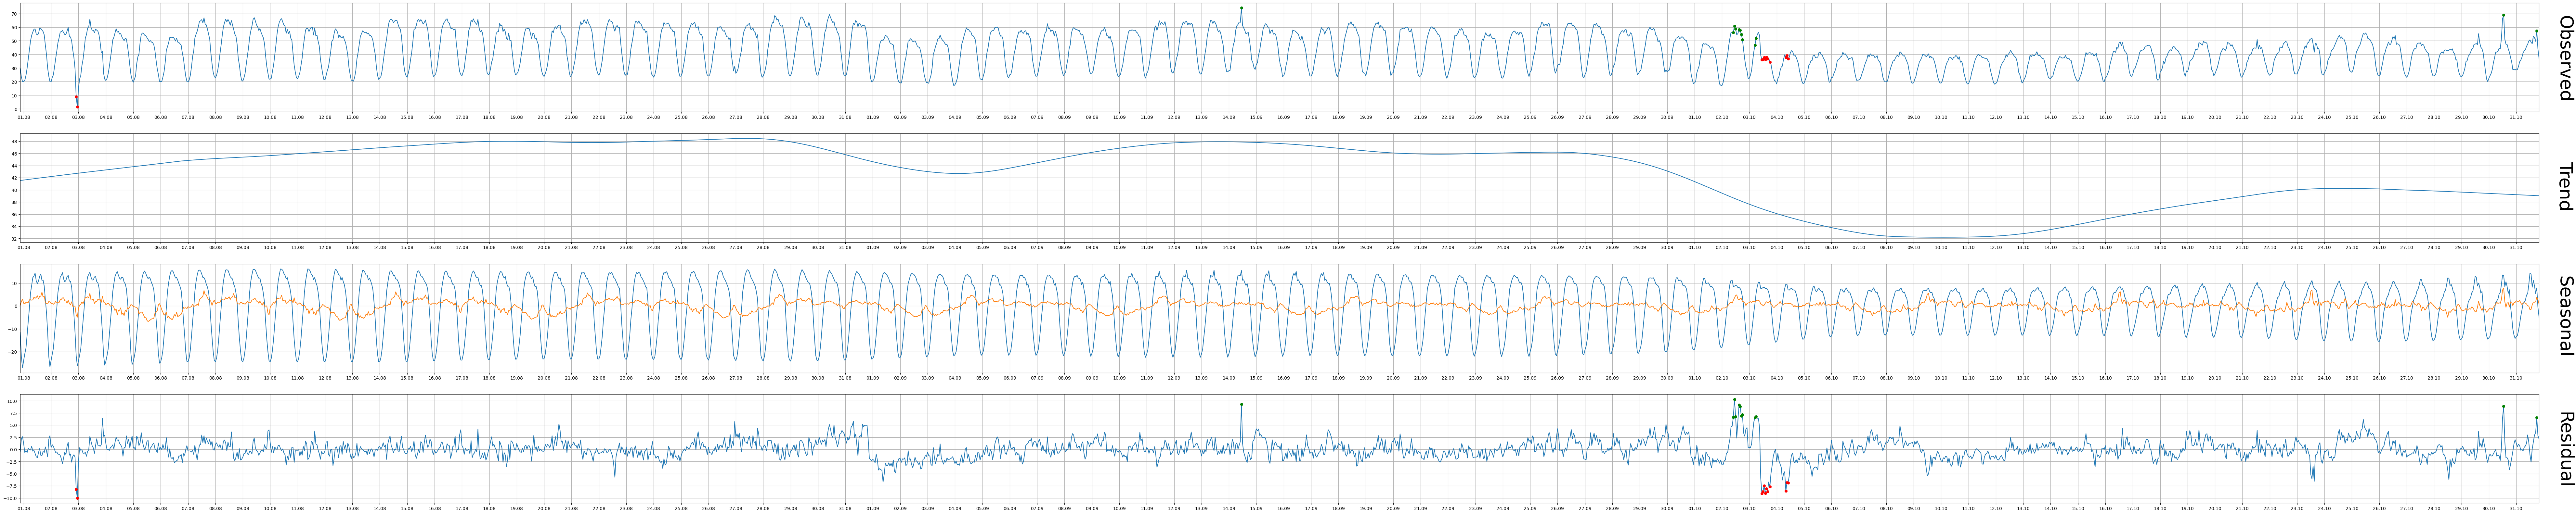

In [30]:
fig, axes = plt.subplots(4, figsize=(100, 20), dpi=100)

a = x[0]
b = x[-1]

for i in range(4):
    axes[i].set_xlim(a, b)
    axes[i].set_xticks(sep)
    axes[i].set_xticklabels(labels)
    axes[i].grid()

axes[0].plot(x, result.observed)
axes[0].scatter(x, highlight_observed_low, s=30, c='r', zorder=10)
axes[0].scatter(x, highlight_observed_high, s=30, c='g', zorder=10)
axes[0].set_title('Observed', x=1.01, y=0.1, rotation = -90, fontsize=40)
#axes[0].axvline(x = x[1525], color = 'y', linewidth=4, alpha=0.6)
#axes[0].axvline(x = x[1779], color = 'y', linewidth=4, alpha=0.6)

axes[1].plot(x, result.trend)
axes[1].set_title('Trend', x=1.01, y=0.3, rotation = -90, fontsize=40)
#axes[1].axvline(x = x[1525], color = 'y', linewidth=4, alpha=0.6)
#axes[1].axvline(x = x[1779], color = 'y', linewidth=4, alpha=0.6)

axes[2].plot(x, result.seasonal)
axes[2].set_title('Seasonal', x=1.01, y=0.15, rotation = -90, fontsize=40)

axes[3].plot(x, result.resid)
axes[3].scatter(x, highlight_residual_low, s=30, c='r', zorder=10)
axes[3].scatter(x, highlight_residual_high, s=30, c='g', zorder=10)
axes[3].set_title('Residual', x=1.01, y=0.15, rotation = -90, fontsize=40)

# plt.savefig('Anomalies.jpg')

plt.show()

In [31]:
# список аномально низкой частоты событий
events_per_url_low = highlight_observed_low[highlight_observed_low.notna()]
events_per_url_low

2023-08-02 22:00:00     8.785714
2023-08-02 23:00:00     1.538462
2023-10-03 11:00:00    36.069705
2023-10-03 12:00:00    36.274528
2023-10-03 13:00:00    37.803052
2023-10-03 14:00:00    36.393158
2023-10-03 15:00:00    37.882295
2023-10-03 16:00:00    36.672012
2023-10-03 18:00:00    34.397174
2023-10-04 08:00:00    37.775718
2023-10-04 09:00:00    39.262494
2023-10-04 10:00:00    36.741858
dtype: float64

In [32]:
# список аномально высокой частоты событий
events_per_url_high = highlight_observed_high[highlight_observed_high.notna()]
events_per_url_high

2023-09-14 11:00:00    74.067729
2023-10-02 10:00:00    56.178218
2023-10-02 11:00:00    60.955780
2023-10-02 12:00:00    58.699243
2023-10-02 15:00:00    58.191311
2023-10-02 16:00:00    57.820199
2023-10-02 17:00:00    54.635593
2023-10-02 18:00:00    50.922774
2023-10-03 05:00:00    46.762887
2023-10-03 06:00:00    51.870968
2023-10-30 13:00:00    69.060271
2023-10-31 18:00:00    57.239362
dtype: float64

# Сумма уникальных URL

In [33]:
x = view.index
sep = [datetime for datetime in view.index if datetime.hour==0]
labels = [s.strftime('%d.%m') for s in sep]

nunique_url_id = view.nunique_url_id

In [34]:
nunique_url_id

event_timestamp
2023-07-31 21:00:00    1079
2023-07-31 22:00:00     942
2023-07-31 23:00:00     873
2023-08-01 00:00:00     840
2023-08-01 01:00:00     830
                       ... 
2023-10-31 16:00:00    2181
2023-10-31 17:00:00    2147
2023-10-31 18:00:00    2068
2023-10-31 19:00:00    1964
2023-10-31 20:00:00    1662
Name: nunique_url_id, Length: 2208, dtype: int64

##### Seasonal Decomposition

In [35]:
result = MSTL(nunique_url_id, periods=[24*1, 24*7]).fit()

##### Анализ остатков

In [36]:
residuals = result.resid[~result.resid.isna()].tolist()

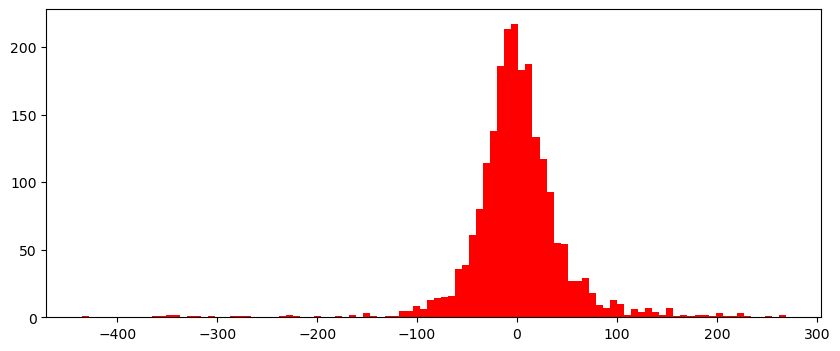

In [37]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=100)
plt.hist(residuals, bins=100, color='r')
plt.show()

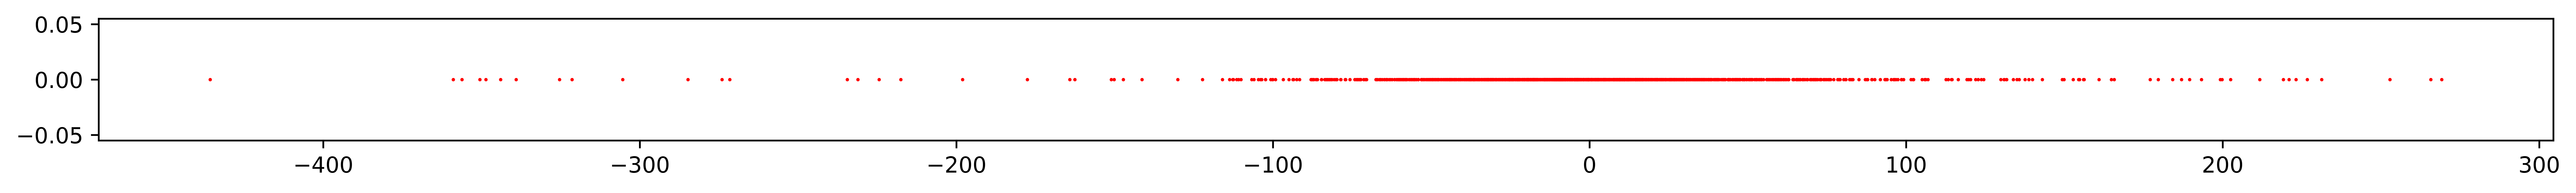

In [38]:
fig, axes = plt.subplots(figsize=(20, 1), dpi=1000)
plt.scatter(residuals, [0]*len(residuals), color='r', s=0.3)
plt.show()

In [39]:
# если True, то остатки не распределены нормально
shapiro(np.array(residuals))[1] < 0.01

True

In [40]:
# если True, то остатки не распределены нормально
kstest(np.array(residuals), 'norm')[1] < 0.01

True

##### Поиск аномалий через выделение 0.5%-ых квантилей с обеих сторон

In [41]:
quantile_ad = QuantileAD(high=0.995, low=0.005)
anomalies = quantile_ad.fit_detect(result.resid[~result.resid.isna()])

In [42]:
# для графика

avg = np.mean(result.resid)

highlight_observed_low = {}
highlight_observed_high = {}
for datetime in result.observed.index:
    if np.isnan(result.resid[datetime]):
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_observed_low[datetime] = np.nan
        highlight_observed_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_observed_low[datetime] = result.observed[datetime]
            highlight_observed_high[datetime] = np.nan
        else:
            highlight_observed_low[datetime] = np.nan
            highlight_observed_high[datetime] = result.observed[datetime]
highlight_observed_low = pd.Series(highlight_observed_low)
highlight_observed_high = pd.Series(highlight_observed_high)

highlight_residual_low = {}
highlight_residual_high = {}
for datetime in result.resid.index:
    if np.isnan(result.resid[datetime]):
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    elif not anomalies[datetime]:
        highlight_residual_low[datetime] = np.nan
        highlight_residual_high[datetime] = np.nan
    else:
        if result.resid[datetime] < avg:
            highlight_residual_low[datetime] = result.resid[datetime]
            highlight_residual_high[datetime] = np.nan
        else:
            highlight_residual_low[datetime] = np.nan
            highlight_residual_high[datetime] = result.resid[datetime]
highlight_residual_low = pd.Series(highlight_residual_low)
highlight_residual_high = pd.Series(highlight_residual_high)

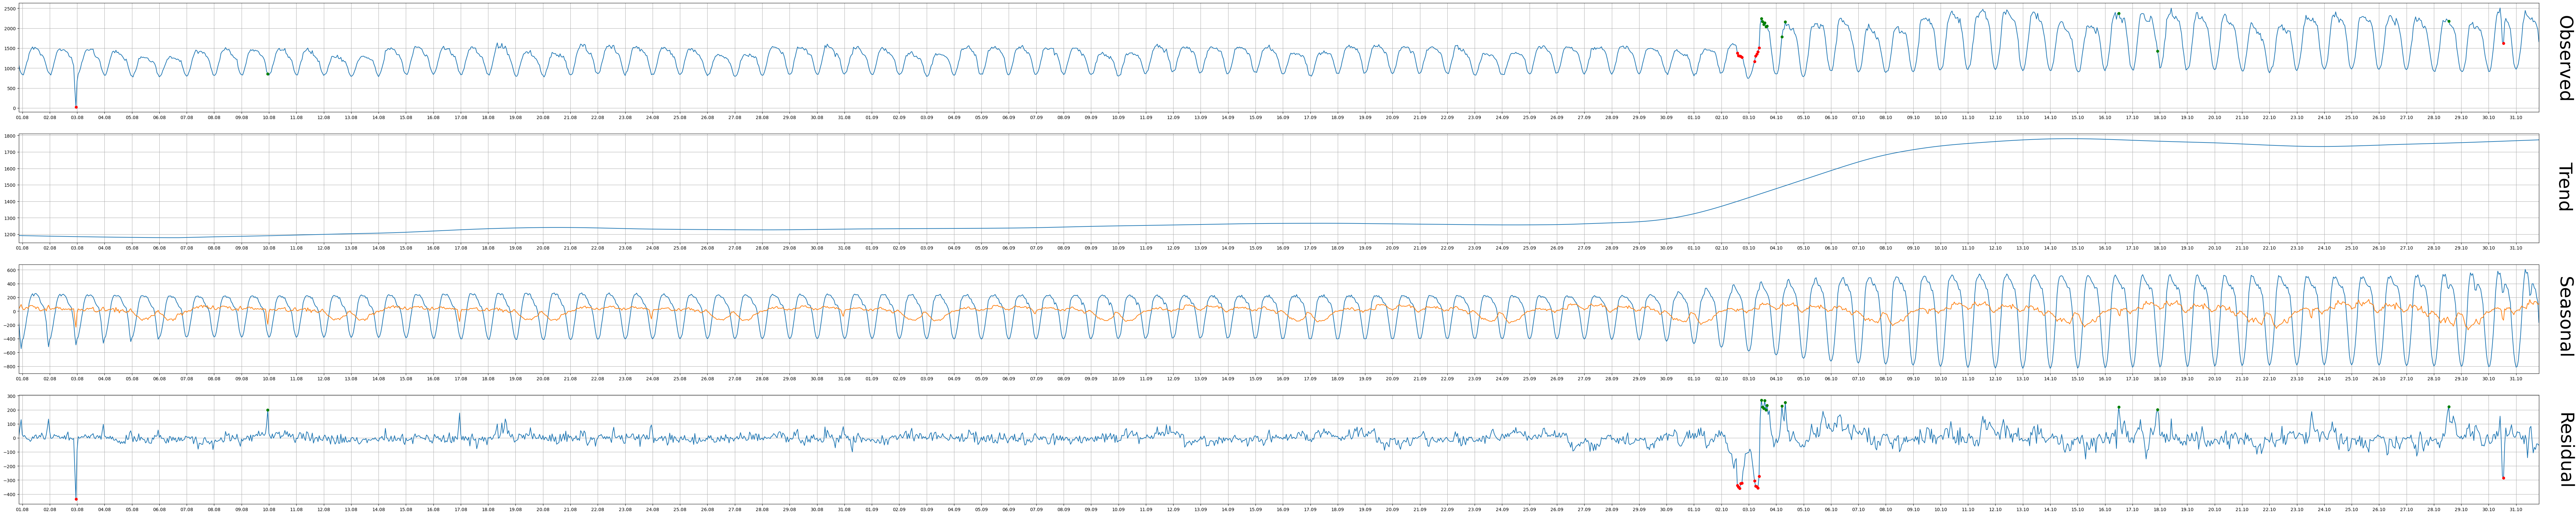

In [43]:
fig, axes = plt.subplots(4, figsize=(100, 20), dpi=100)

a = x[0]
b = x[-1]

for i in range(4):
    axes[i].set_xlim(a, b)
    axes[i].set_xticks(sep)
    axes[i].set_xticklabels(labels)
    axes[i].grid()

axes[0].plot(x, result.observed)
axes[0].scatter(x, highlight_observed_low, s=30, c='r', zorder=10)
axes[0].scatter(x, highlight_observed_high, s=30, c='g', zorder=10)
axes[0].set_title('Observed', x=1.01, y=0.1, rotation = -90, fontsize=40)
#axes[0].axvline(x = x[1443], color = 'y', linewidth=4, alpha=0.6)

axes[1].plot(x, result.trend)
axes[1].set_title('Trend', x=1.01, y=0.3, rotation = -90, fontsize=40)
#axes[1].axvline(x = x[1443], color = 'y', linewidth=4, alpha=0.6)

axes[2].plot(x, result.seasonal)
axes[2].set_title('Seasonal', x=1.01, y=0.15, rotation = -90, fontsize=40)

axes[3].plot(x, result.resid)
axes[3].scatter(x, highlight_residual_low, s=30, c='r', zorder=10)
axes[3].scatter(x, highlight_residual_high, s=30, c='g', zorder=10)
axes[3].set_title('Residual', x=1.01, y=0.15, rotation = -90, fontsize=40)

# plt.savefig('Anomalies.jpg')

plt.show()

In [44]:
# список аномально низкой частоты событий
nunique_url_low = highlight_observed_low[highlight_observed_low.notna()]
nunique_url_low

2023-08-02 23:00:00      26.0
2023-10-02 14:00:00    1374.0
2023-10-02 15:00:00    1312.0
2023-10-02 16:00:00    1307.0
2023-10-02 17:00:00    1298.0
2023-10-02 18:00:00    1269.0
2023-10-03 05:00:00    1164.0
2023-10-03 06:00:00    1302.0
2023-10-03 07:00:00    1354.0
2023-10-03 08:00:00    1407.0
2023-10-03 09:00:00    1510.0
2023-10-30 13:00:00    1626.0
dtype: float64

In [45]:
# список аномально высокой частоты событий
nunique_url_high = highlight_observed_high[highlight_observed_high.notna()]
nunique_url_high

2023-08-09 23:00:00     859.0
2023-10-03 11:00:00    2238.0
2023-10-03 12:00:00    2171.0
2023-10-03 13:00:00    2097.0
2023-10-03 14:00:00    2134.0
2023-10-03 15:00:00    2039.0
2023-10-03 16:00:00    2058.0
2023-10-04 05:00:00    1787.0
2023-10-04 08:00:00    2158.0
2023-10-16 12:00:00    2374.0
2023-10-17 22:00:00    1429.0
2023-10-28 13:00:00    2178.0
dtype: float64

# Категории

In [46]:
# найдем все часы, в которые случались события не во всех семи категориях
view[view['nunique_product_category_id']<7]

event_count  nunique_url_id  nunique_product_category_id  \
event_timestamp                                                                 
2023-08-02 23:00:00           40              26                            6   

                     week  month  events_per_url  
event_timestamp                                   
2023-08-02 23:00:00    31      8        1.538462

In [47]:
category_low = x[50]
category_low

Timestamp('2023-08-02 23:00:00')

In [48]:
# в какой именно категории отсутсвовали события?
categories_50 = df[df['event_timestamp']==x[50]]['product_category_id'].unique()
for category in df['product_category_id'].unique():
    if category not in categories_50:
        print('в 2023-08-02 23:00:00 отсутствовали события в категории №' + str(category))

в 2023-08-02 23:00:00 отсутствовали события в категории №2


# Сопоставление разных аномалий

event_count_low    
event_count_high   
events_per_url_low   
events_per_url_high   
nunique_url_low   
nunique_url_high  
category_low   

event_count_start  
events_per_url_start  
events_per_url_end  
nunique_url_start

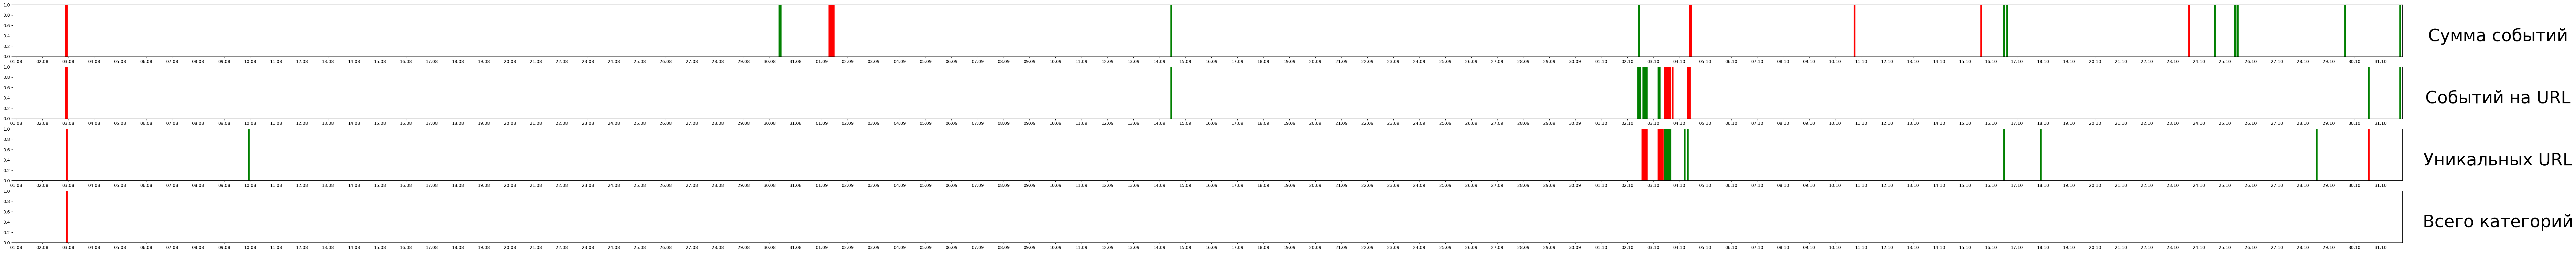

In [49]:
fig, axes = plt.subplots(4, figsize=(100, 10), dpi=100)

a = x[0]
b = x[-1]

axes[0].set_xlim(a, b)
for datetime in event_count_low.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[0].axvline(x=x[i], color = 'r', linewidth=4)
for datetime in event_count_high.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[0].axvline(x=x[i], color = 'g', linewidth=4)
# for i in range(len(x)):
#         if x[i] == event_count_start:
#             axes[0].axvspan(x[i], x[-1], alpha=0.2, color='y')
axes[0].set_title('Сумма событий', x=1.04, y=0.25, fontsize=40)

axes[1].set_xlim(a, b)
for datetime in events_per_url_low.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[1].axvline(x=x[i], color = 'r', linewidth=4)
for datetime in events_per_url_high.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[1].axvline(x=x[i], color = 'g', linewidth=4)
# for i in range(len(x)):
#         if x[i] == events_per_url_start:
#             for j in range(i, len(x)):
#                 if x[j] == events_per_url_end:
#                     axes[1].axvspan(x[i], x[j], alpha=0.2, color='y')
#                     axes[1].axvspan(x[j], x[-1], alpha=0.1, color='b')
axes[1].set_title('Событий на URL', x=1.04, y=0.25, fontsize=40)

axes[2].set_xlim(a, b)
for datetime in nunique_url_low.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[2].axvline(x=x[i], color = 'r', linewidth=4)
for datetime in nunique_url_high.index:
    for i in range(len(x)):
        if x[i] == datetime:
            axes[2].axvline(x=x[i], color = 'g', linewidth=4)
# for i in range(len(x)):
#         if x[i] == nunique_url_start:
#             axes[2].axvspan(x[i], x[-1], alpha=0.2, color='y')
axes[2].set_title('Уникальных URL', x=1.04, y=0.25, fontsize=40)

axes[3].set_xlim(a, b)
for i in range(len(x)):
    if x[i] == category_low:
        axes[3].axvline(x=x[i], color = 'r', linewidth=4)
axes[3].set_title('Всего категорий', x=1.04, y=0.25, fontsize=40)

for i in range(4):
    axes[i].set_xticks(sep)
    axes[i].set_xticklabels(labels)

plt.show()